### Rain prediction - testing (Prophet forecast)

This is a collection of experiments with Open Meteo's historical weather data. The Open Meteo historical data will "simulate" future predictions, which might make the results overly optimistic.

In the best scenario, we should use conventional weather forecasts from an API and use those variables as extra regressors instead.

In [106]:
import pandas as pd

# pip install phik
import phik

# pip install prophet
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

**Step 1: Open the weather data**

Unfortunately some of the important variables (soil moisture etc.) seem to be missing in the 15 minute data options.

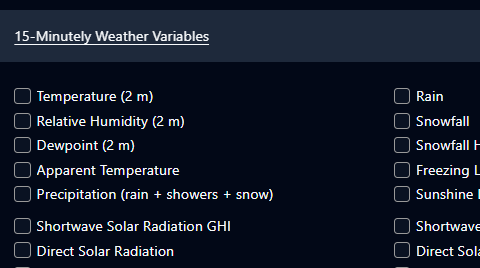

**Step 2: Get additional weather data from Open Meteo**

See API:
https://open-meteo.com/en/docs/historical-forecast-api

**NOTE:** when you download a CSV-file from Open Meteo, you have some meta information on top of the CSV-file, which you have to remove before you load it into pandas.

You can just open the csv-file in a Notepad or something similar, and remove the first rows until the real data begins. In the example below, the first three rows need to be deleted.

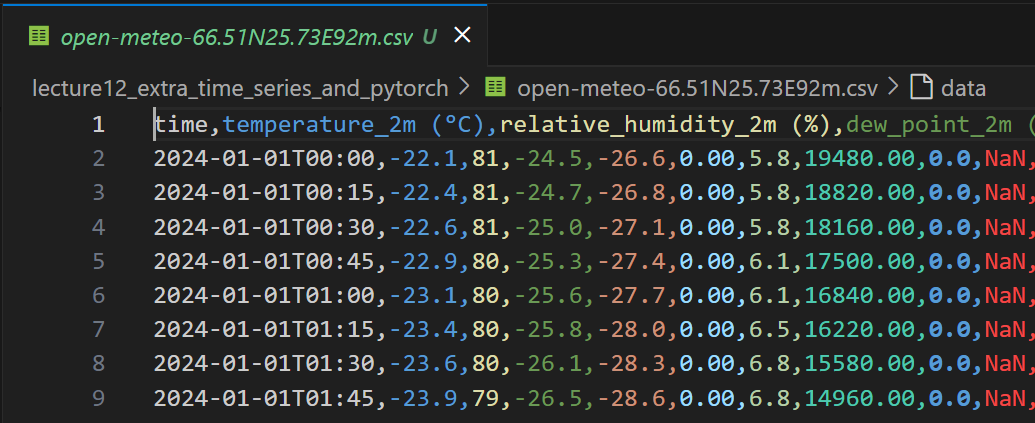

In [107]:
# using a CSV snapshot from autumn 2024 somewhere in Jyväskylä

# load data snapshot and rename columns
df = pd.read_csv("open-meteo-66.51N25.73E92m.csv")
df = df.rename(columns={"time": "Timestamp"})
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

# round timestamp  to nearest 15 min and aggregate (group by) with average values
df["rounded_hour"] = df["Timestamp"].dt.round("15min")
df_meteo_avg = df.groupby("rounded_hour").mean(numeric_only=True).reset_index()
df_meteo_avg = df_meteo_avg.rename(columns={"rounded_hour": "Timestamp"})

# save the processed dataset back to df
df_meteo_avg.head(3)
df = df_meteo_avg

**Step 3: Combine (merge) the Local weather station and Open Meteo Data**

**Time-series datasets should be regular => uniform intervals without any missing parts of sequence (in our case, no missing hours in any day, because this breaks the signal)**

Note: for ML models, sequence is just a sequence. It doesn't inherently know if parts of the sequence are missing in real life. In our case, missing hours means we have missing measurement events in the data.

In [108]:
# final check, is our time series dataset regular (even steps with no missing hours)
diffs = df['Timestamp'].diff()
is_regular = diffs.iloc[1:].eq(pd.Timedelta('1h')).all()
print(is_regular)
print()

#if there are gaps, identify where they are:
gaps = df.loc[diffs > pd.Timedelta('1h'), 'Timestamp']
print("Missing indeces:")
print(gaps)

False

Missing indeces:
Series([], Name: Timestamp, dtype: datetime64[ns])


In [109]:
# re-index for interpolation
df = df.set_index('Timestamp').sort_index()
full_index = pd.date_range(df.index.min(), df.index.max(), freq='h')
df = df.reindex(full_index)

# DOUBLE-CHECK THAT THIS INTERPOLATION WORKED CORRECTLY

# interpolate and reset index
df = df.interpolate(method='time')
df = df.reset_index().rename(columns={'index': 'Timestamp'})

**Step 4: Prophet forecasting**

In [110]:
df.columns

Index(['Timestamp', 'temperature_2m (°C)', 'relative_humidity_2m (%)',
       'dew_point_2m (°C)', 'apparent_temperature (°C)', 'precipitation (mm)',
       'wind_gusts_10m (km/h)', 'visibility (m)', 'cape (J/kg)',
       'lightning_potential (J/kg)', 'is_day ()', 'rain (mm)', 'snowfall (cm)',
       'snowfall_height (m)', 'freezing_level_height (m)',
       'sunshine_duration (s)', 'weather_code (wmo code)',
       'wind_speed_10m (km/h)', 'wind_speed_80m (km/h)',
       'wind_direction_10m (°)', 'wind_direction_80m (°)'],
      dtype='object')

In [111]:
# Prophet requires a certain naming convention
# ds => timestamp field / sequence number => has to be in DateTime-format (pandas)
# y => target variable
# support variables / extra regressors can be called as they are

# PROPHET REQUIRES A NAMING CONVENTION
# target is y , timestamp is ds

# [EXPERIMENT IDEA]: try a different local weather variables
# for prediction. this one uses precipitation as target

# fix the column names to match better with Prophet requirements
df = df.rename({'precipitation (mm)': "y", "Timestamp": "ds"}, axis=1)
df['ds'] = pd.to_datetime(df['ds'], format="mixed")
df_original = df.copy()
df

original_weather_columns = list(df.columns)
original_weather_columns.remove("ds")


**OPTIONAL: You can also attempt using a filter (SavGol, Kalman etc.) in order to simplify the rain signal**

Just remember: traditional (electronics) filter methods are usually irreversible => we can't reliably convert back to actual rain amounts after filtering has been performed.

In [112]:
# # optional test.... Savgol filter
# from scipy.signal import savgol_filter

# # [EXPERIMENT IDEA]: adjust the window length, polyorder to adjust aggressiveness 
# # of the Savitzky-Golay filter. Or just try another filter, like Kalman

# # see this notebook for other filter/analysis ideas:
# # https://colab.research.google.com/drive/1yAeDBAPuhxg0-OgIsTB4pLggwCg4yl8k?usp=sharing

# # apply Savitzky-Golay filter with a window size and polynomial order
# # original values used with this code example: window_length = 6, polyorder = 5
# df['signal_smooth_sg'] = savgol_filter(df['y'], window_length=36, polyorder=12)

# # plot the original and smoothed data
# plt.plot(df['y'], label='Original signal')
# plt.plot(df['signal_smooth_sg'], label='Savitzky-Golay Smoothed Signal', linestyle='--')
# plt.legend()
# plt.show()

# # replace original with SavGol and save original y for later purposes
# # df_original = pd.DataFrame(df['y'].copy())
# df['y'] = df['signal_smooth_sg']

In [113]:
df

,ds,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),y,wind_gusts_10m (km/h),visibility (m),cape (J/kg),lightning_potential (J/kg),...,rain (mm),snowfall (cm),snowfall_height (m),freezing_level_height (m),sunshine_duration (s),weather_code (wmo code),wind_speed_10m (km/h),wind_speed_80m (km/h),wind_direction_10m (°),wind_direction_80m (°)
0,2024-01-01 00:00:00,-22.1,81.0,-24.5,-26.6,0.0,5.8,19480.0,0.0,NaN,...,0.0,0.0,NaN,-1120.0,0.0,0.0,3.2,14.2,126.0,83.0
1,2024-01-01 01:00:00,-23.1,80.0,-25.6,-27.7,0.0,6.1,16840.0,0.0,NaN,...,0.0,0.0,NaN,-1170.0,0.0,0.0,4.0,13.3,116.0,87.0
2,2024-01-01 02:00:00,-24.1,79.0,-26.8,-28.8,0.0,7.2,14320.0,0.0,NaN,...,0.0,0.0,NaN,-1220.0,0.0,0.0,4.7,14.8,123.0,94.0
3,2024-01-01 03:00:00,-24.8,78.0,-27.5,-29.5,0.0,7.6,18920.0,0.0,NaN,...,0.0,0.0,NaN,-1240.0,0.0,0.0,4.7,13.3,118.0,93.0
4,2024-01-01 04:00:00,-25.4,77.0,-28.3,-30.1,0.0,7.6,10660.0,0.0,NaN,...,0.0,0.0,NaN,-1270.0,0.0,0.0,4.3,12.3,112.0,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,2024-12-31 19:00:00,-4.2,87.0,-6.0,-8.5,0.0,17.6,16140.0,0.0,NaN,...,0.0,0.0,-260.0,-240.0,0.0,3.0,9.7,20.4,271.0,296.0
8780,2024-12-31 20:00:00,-5.8,90.0,-7.2,-10.4,0.0,18.7,13880.0,0.0,NaN,...,0.0,0.0,-320.0,-310.0,0.0,3.0,10.4,20.8,267.0,293.0
8781,2024-12-31 21:00:00,-6.5,90.0,-7.9,-11.1,0.0,18.4,16240.0,0.0,NaN,...,0.0,0.0,-330.0,-320.0,0.0,3.0,10.4,20.3,271.0,287.0
8782,2024-12-31 22:00:00,-6.6,86.0,-8.6,-11.3,0.0,19.1,27240.0,0.0,NaN,...,0.0,0.0,-380.0,-360.0,0.0,2.0,10.4,20.5,269.0,281.0


**Scaling the values**

In [114]:
# initialize scaler
scaler = MinMaxScaler()

# save the original min/max so we can convert the Prophet's output
# back to original values later...
# ~you can use inverse-transform with this as well
# y_min = df['y'].min()
# y_max = df['y'].max()

df['y'] = scaler.fit_transform(df[['y']])

**Take a smaller subset of the data, e.g. 100-200 points**

**MODIFY THIS PART IN ORDER TO SEE A DIFFERENT SIGNAL FOR FORECASTING**

In [115]:
# Keep full dataset before slicing
df_full = df.copy()

# 2000 is a good index, 500 also, 1600 is super cool with SavGol!!
# problematic index => 3150
# around 150, lots of problems
# only take 100 points, let's experiment on that

# [EXPERIMENT IDEA]: adjust the index slice size, how about 50, 100, 150, 200...?

# the cutoff point for index 

# try index cuts: 100, 200, 470, 500
# if you enable snowfall, try index 470
# => even with the perfect helper variable => it still misses one spike in the data
index_cut = 100

# adjust this only if you want to take more or less 
# data for the forecast training

slice_length = 200

# take a slice, this uses 100 points
df = df_full.iloc[index_cut:index_cut + slice_length].copy()
print(f"Amount of selected data points: {len(df)}")

Amount of selected data points: 200


**Optional: Visualize the whole dataset**

You can uncomment this block of code if you just want to see the whole dataset at once.

In [116]:
# # plot everything we have
# df_copy = df.copy()
# df_copy['sequence'] = df_copy.index + 1
# df_copy = df_copy.drop(['ds'], axis=1)
# df_copy.set_index("sequence", inplace=True)

# plt.figure(figsize=(12, 6))

# for column in df_copy.columns:
#     plt.plot(df_copy.index, df_copy[column], label=column)

# plt.title("All continuous variables")
# plt.xlabel("Time")
# plt.ylabel("Value")

# plt.legend(title="Variables")
# plt.grid(True, linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()

In [117]:
# Got this from ChatGPT, study both at the same time!

# we need jinja2 for visualizations
# pip install jinja2
# cols_to_use = [c for c in df.columns if c not in original_weather_columns]
cols_to_use = list(df.columns)
cols_to_use.remove("ds")

savgol_used = False

# remove the SavGol-signal from original weather columns list if present
if "signal_smooth_sg" in cols_to_use:
    cols_to_use.remove("signal_smooth_sg")
    savgol_used = True

# only use the variables not in the original local weather station
corr_pearson = df[cols_to_use].corr()['y']
corr_phik = df[cols_to_use].phik_matrix()['y']

# if you wish to see the original local weather station variables too, try:
# corr_pearson = df.corr()['y']
# corr_phik = df.phik_matrix()['y']

comparison = pd.concat([corr_pearson, corr_phik], axis=1)
comparison.columns = ['Pearson', 'Phik']
comparison = comparison.sort_values('Phik', ascending=False)

comparison.style.background_gradient(cmap='coolwarm', axis=0).set_caption("Pearson vs Phik Correlations with y")

# study how powerful each variable is towards detecting rain

interval columns not set, guessing: ['temperature_2m (°C)', 'relative_humidity_2m (%)', 'dew_point_2m (°C)', 'apparent_temperature (°C)', 'y', 'wind_gusts_10m (km/h)', 'visibility (m)', 'cape (J/kg)', 'lightning_potential (J/kg)', 'is_day ()', 'rain (mm)', 'snowfall (cm)', 'snowfall_height (m)', 'freezing_level_height (m)', 'sunshine_duration (s)', 'weather_code (wmo code)', 'wind_speed_10m (km/h)', 'wind_speed_80m (km/h)', 'wind_direction_10m (°)', 'wind_direction_80m (°)']


c:\Users\tuomas.valtanen\DL2025lecturenotes2\DeepLearning2025\.venv\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable lightning_potential (J/kg) for analysis 0. Dropping this column
  warnings.warn(


,Pearson,Phik
y,1.000000,1.000000
snowfall (cm),0.984980,0.999953
snowfall_height (m),0.022190,0.719923
weather_code (wmo code),0.917932,0.673839
wind_speed_80m (km/h),0.108036,0.407338
visibility (m),-0.120140,0.356605
relative_humidity_2m (%),0.267734,0.345425
cape (J/kg),0.048548,0.318202
dew_point_2m (°C),0.171241,0.285233
apparent_temperature (°C),0.149020,0.273912


In [118]:
# let's quickly see what our options are for extra regressors
df[cols_to_use].columns

Index(['temperature_2m (°C)', 'relative_humidity_2m (%)', 'dew_point_2m (°C)',
       'apparent_temperature (°C)', 'y', 'wind_gusts_10m (km/h)',
       'visibility (m)', 'cape (J/kg)', 'lightning_potential (J/kg)',
       'is_day ()', 'rain (mm)', 'snowfall (cm)', 'snowfall_height (m)',
       'freezing_level_height (m)', 'sunshine_duration (s)',
       'weather_code (wmo code)', 'wind_speed_10m (km/h)',
       'wind_speed_80m (km/h)', 'wind_direction_10m (°)',
       'wind_direction_80m (°)'],
      dtype='object')

In [119]:
# initialize the model and add helper variables
# disable seasonality features, because within 100 hours
# there's not much seasonality going on here
# changepoint_prior_scale affects trend smoothness
# [EXPERIMENT IDEA]: try adjusting the prior scale value
model = Prophet(scaling='minmax', 
                yearly_seasonality=False,
                weekly_seasonality=False,
                daily_seasonality=False,
                seasonality_mode='additive',  
                changepoint_prior_scale=0.01)


# [EXPERIMENT IDEA]: try different extra regressors 
# See the colored Pearson / Phik-matrix tool in order to
# see what variables seem to be the most impactful one this time

# put our regressor variable names into a list for easier experimentation

# try enabling the snowfall in order to
# see how well the model starts to work
# because technically snowfall is used to calculate precipitation
# and this data is using actual future values, not weather forecasts as we should
regressors = [
              "dew_point_2m (°C)", 
              "relative_humidity_2m (%)",	
              'wind_speed_10m (km/h)',
              #'snowfall (cm)'
              ]

# add regressors to forecast model
# [EXPERIMENT IDEA]: you can also apparently assign prior scale weights
# to regressors, for example:
# model.add_regressor(reg, prior_scale=10.0)
# however if this is done in a loop, it assigns the same
# weight to each regressor. a better way would have specific 
# weights for each regressor
for reg in regressors:
    model.add_regressor(reg)

# fit the model with the data
model.fit(df)

13:15:30 - cmdstanpy - INFO - Chain [1] start processing
13:15:30 - cmdstanpy - INFO - Chain [1] done processing


In [120]:
# make a helper list needed later, including the regressors names
needed_columns = ["ds", "y"] + regressors
df = df[regressors]
df

,dew_point_2m (°C),relative_humidity_2m (%),wind_speed_10m (km/h)
100,-26.4,90.0,9.0
101,-25.2,91.0,10.4
102,-24.2,91.0,10.8
103,-23.6,91.0,7.9
104,-22.9,89.0,5.4
...,...,...,...
295,-19.6,83.0,6.1
296,-18.9,84.0,6.1
297,-18.4,84.0,6.5
298,-16.4,85.0,7.2


In [121]:
# Define how far ahead you want to forecast, this case 24 hours
# [EXPERIMENT IDEA]: experiment with the future horizon value
# 24 hours might be too much
future_horizon = 24 

# Create future timestamps, adjust 1h if using a different time scope
future = model.make_future_dataframe(periods=future_horizon, freq="1h")

# define the needed columns for future DataFrame merge later
needed_columns = ["ds"] + regressors

# Now attach the real regressors from df_full by merging on 'ds'
future = future.merge(
    df_full[needed_columns],
    on="ds",
    how="left"
)

# Check for missing values in regressors
print(future.isna().sum())

# Predict using these regressors
forecast = model.predict(future)


ds                          0
dew_point_2m (°C)           0
relative_humidity_2m (%)    0
wind_speed_10m (km/h)       0
dtype: int64


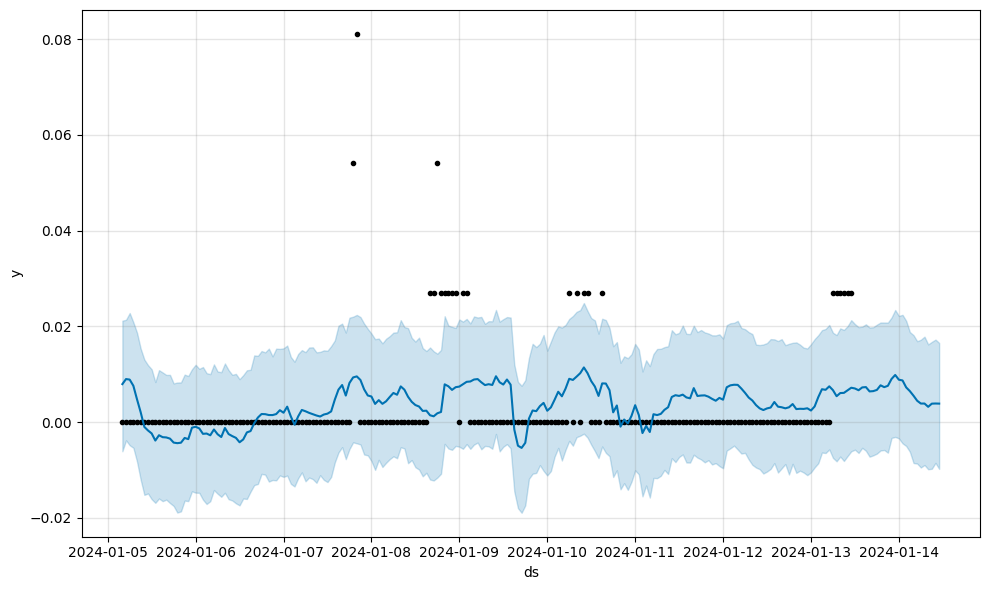

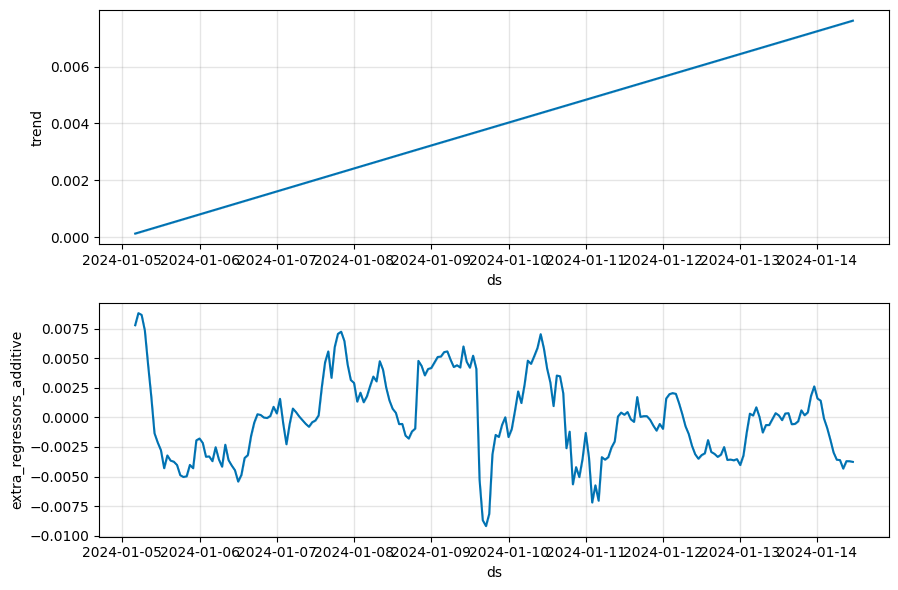

In [122]:
# invert the scaling of the target back to original
# forecast["yhat_original_range"] = forecast['yhat'] * (y_max - y_min) + y_min
forecast['yhat_original_range'] = scaler.inverse_transform(forecast[['yhat']])

# plot some details
fig_forecast = model.plot(forecast)
fig_components = model.plot_components(forecast)

[EXPERIMENT IDEA]: What if we used the Prophet trend value instead of forecast values to determine the overall trends?

In [123]:
# df_full contains the entire original dataset with actual y-values
comparison = forecast[["ds", "yhat", "yhat_lower", "yhat_upper", "yhat_original_range"]].merge(
    df_full[["ds", "y"]],
    on="ds",
    how="left"   # use left join so forecast dates remain, actual y filled where available
)

# Clip values to be >= 0
comparison["y"] = comparison["y"].clip(lower=0)
comparison["yhat"] = comparison["yhat"].clip(lower=0)
comparison["yhat_lower"] = comparison["yhat_lower"].clip(lower=0)
comparison["yhat_upper"] = comparison["yhat_upper"].clip(lower=0)
comparison["yhat_original_range"] = comparison["yhat_original_range"].clip(lower=0)

comparison['y_original_range'] = scaler.inverse_transform(comparison[['y']])


In [124]:
# this thingamajig was happily created by ChatGPT
# not completely sure if always works, let's keep this in mind
def determine_trend(data, threshold):
    # Convert input to a NumPy array if it's not already
    data = np.array(data)

    # Calculate differences between consecutive elements
    differences = np.diff(data)

    # Count the number of upward, downward, and neutral movements
    up_count = np.sum(differences > threshold)
    down_count = np.sum(differences < -threshold)
    # neutral_count = np.sum(np.abs(differences) <= threshold)
    
    # Determine the overall trend based on counts
    if up_count > down_count:
        return "up"
    elif down_count > up_count:
        return "down"
    else:
        return "neutral"

# experiment on the threshold so you can find a good sensitivity for the trends
threshold = 0.005
sample = comparison
trend = determine_trend(sample['yhat_original_range'][-future_horizon:], threshold)
print(f"The overall trend is: {trend}")

immediate_hours = 4

trend = determine_trend(sample['yhat_original_range'][len(df):len(df) + immediate_hours], threshold)
print(f"The immediate trend ({immediate_hours} hours) in forecast is: {trend}")

# analyze overall Prophet trend
start_trend = float(forecast['trend'].iloc[0])
end_trend = float(forecast['trend'].iloc[-1])

if end_trend > start_trend:
    trend = "up"
elif end_trend < start_trend:
    trend = "down"
else:
    trend = "neutral"

# it seems Prophet trend is always towards up??
print(f"The overall Prophet trend evaluation is: {trend}")



The overall trend is: neutral
The immediate trend (4 hours) in forecast is: neutral
The overall Prophet trend evaluation is: up


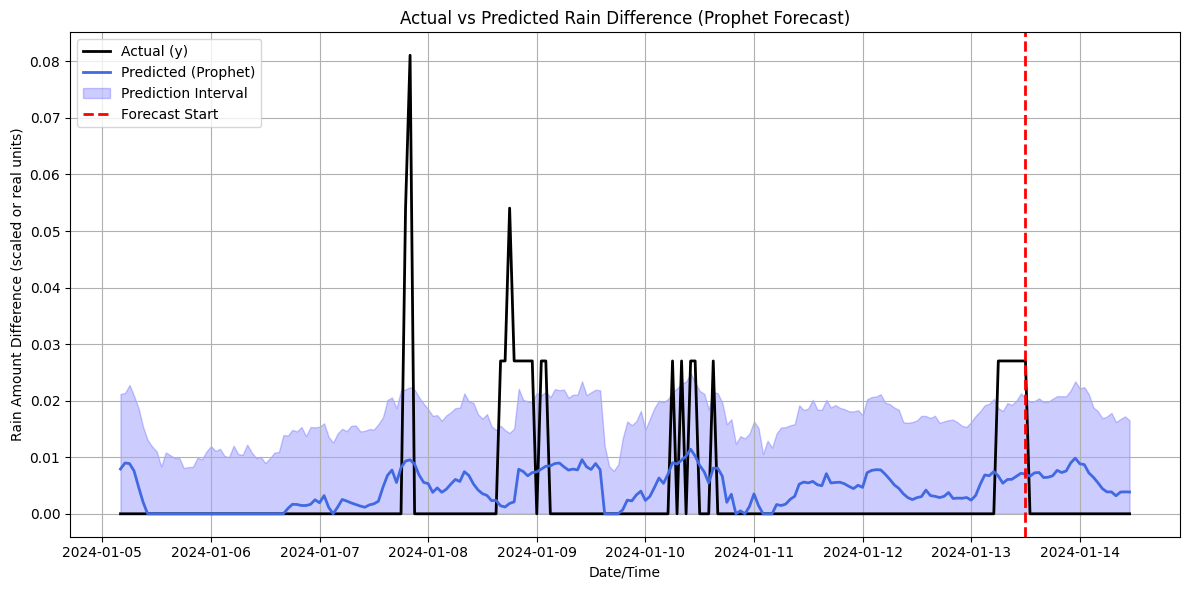

In [125]:
# Determine where the forecast period starts (the last 24 points)
split_index = len(comparison) - future_horizon
split_date = comparison["ds"].iloc[split_index]

plt.figure(figsize=(12, 6))

# Plot actual y
plt.plot(comparison["ds"], comparison["y"], label="Actual (y)", color="black", linewidth=2)

# Plot predicted yhat
plt.plot(comparison["ds"], comparison["yhat"], label="Predicted (Prophet)", color="royalblue", linewidth=2)

# Add Prophet's uncertainty interval
plt.fill_between(
    comparison["ds"],
    comparison["yhat_lower"],
    comparison["yhat_upper"],
    color="blue",
    alpha=0.2,
    label="Prediction Interval"
)

# Add vertical line before future predictions
plt.axvline(
    x=split_date,
    color="red",
    linestyle="--",
    linewidth=2,
    label="Forecast Start"
)

# Labels and legend
plt.title("Actual vs Predicted Rain Difference (Prophet Forecast)")
plt.xlabel("Date/Time")
plt.ylabel("Rain Amount Difference (scaled or real units)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# snowfall seems to be super well correlated to rain / precipitation here, which makes sense
# still, however, misses a major spike every now and then

In [126]:
# get some quick metrics
mask = ~comparison["y"].isna()
rmse = np.sqrt(mean_squared_error(comparison.loc[mask, "y"], comparison.loc[mask, "yhat"]))
r2 = r2_score(comparison.loc[mask, "y"], comparison.loc[mask, "yhat"])

# preferable RMSE should be close to 0.0 and R-squared as close to 1.0 as possible
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")

RMSE: 0.010
R²:   0.071
